In [23]:

%reload_ext autoreload
%autoreload 2
import pandas as pd
pd.set_option('display.max_rows', None)



In [24]:
# Config dict to set the logging level
import logging.config
DEFAULT_LOGGING = {
    'version': 1,
    'disable_existing_loggers': False,
    'loggers': {
        '': {
            'level': 'INFO',
        },
    }
}

logging.config.dictConfig(DEFAULT_LOGGING)
# Disabling warnings output
import warnings
from sklearn.exceptions import DataConversionWarning, ConvergenceWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)
warnings.filterwarnings(action='ignore', category=ConvergenceWarning)
warnings.filterwarnings(action='ignore', category=UserWarning)

#!pip install dowhy
import dowhy


import numpy as np
import matplotlib.pyplot as plt

In [25]:
dataset = pd.read_csv('https://raw.githubusercontent.com/Sid-darthvader/DoWhy-The-Causal-Story-Behind-Hotel-Booking-Cancellations/master/hotel_bookings.csv')
dataset.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03


In [26]:
dataset.columns

Index(['hotel', 'is_canceled', 'lead_time', 'arrival_date_year',
       'arrival_date_month', 'arrival_date_week_number',
       'arrival_date_day_of_month', 'stays_in_weekend_nights',
       'stays_in_week_nights', 'adults', 'children', 'babies', 'meal',
       'country', 'market_segment', 'distribution_channel',
       'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'reserved_room_type',
       'assigned_room_type', 'booking_changes', 'deposit_type', 'agent',
       'company', 'days_in_waiting_list', 'customer_type', 'adr',
       'required_car_parking_spaces', 'total_of_special_requests',
       'reservation_status', 'reservation_status_date'],
      dtype='object')

In [27]:
# Total stay in nights
dataset['total_stay'] = dataset['stays_in_week_nights']+dataset['stays_in_weekend_nights']
# Total number of guests
dataset['guests'] = dataset['adults']+dataset['children'] +dataset['babies']
# Creating the different_room_assigned feature
dataset['different_room_assigned']=0
slice_indices =dataset['reserved_room_type']!=dataset['assigned_room_type']
dataset.loc[slice_indices,'different_room_assigned']=1
# Deleting older features
dataset = dataset.drop(['stays_in_week_nights','stays_in_weekend_nights','adults','children','babies'
                        ,'reserved_room_type','assigned_room_type'],axis=1)
dataset.columns

Index(['hotel', 'is_canceled', 'lead_time', 'arrival_date_year',
       'arrival_date_month', 'arrival_date_week_number',
       'arrival_date_day_of_month', 'meal', 'country', 'market_segment',
       'distribution_channel', 'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'booking_changes', 'deposit_type',
       'agent', 'company', 'days_in_waiting_list', 'customer_type', 'adr',
       'required_car_parking_spaces', 'total_of_special_requests',
       'reservation_status', 'reservation_status_date', 'total_stay', 'guests',
       'different_room_assigned'],
      dtype='object')

In [28]:
dataset.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,meal,country,market_segment,...,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,total_stay,guests,different_room_assigned
0,Resort Hotel,0,342,2015,July,27,1,BB,PRT,Direct,...,0,Transient,0.0,0,0,Check-Out,2015-07-01,0,2.0,0
1,Resort Hotel,0,737,2015,July,27,1,BB,PRT,Direct,...,0,Transient,0.0,0,0,Check-Out,2015-07-01,0,2.0,0
2,Resort Hotel,0,7,2015,July,27,1,BB,GBR,Direct,...,0,Transient,75.0,0,0,Check-Out,2015-07-02,1,1.0,1
3,Resort Hotel,0,13,2015,July,27,1,BB,GBR,Corporate,...,0,Transient,75.0,0,0,Check-Out,2015-07-02,1,1.0,0
4,Resort Hotel,0,14,2015,July,27,1,BB,GBR,Online TA,...,0,Transient,98.0,0,1,Check-Out,2015-07-03,2,2.0,0


In [29]:
dataset.isnull().sum() # Country,Agent,Company contain 488,16340,112593 missing entries
dataset = dataset.drop(['agent','company'],axis=1)
# Replacing missing countries with most freqently occuring countries
dataset['country']= dataset['country'].fillna(dataset['country'].mode()[0])

In [30]:
dataset = dataset.drop(['reservation_status','reservation_status_date','arrival_date_day_of_month'],axis=1)
dataset = dataset.drop(['arrival_date_year'],axis=1)
dataset = dataset.drop(['distribution_channel'], axis=1)

In [31]:
# Replacing 1 by True and 0 by False for the experiment and outcome variables
dataset['different_room_assigned']= dataset['different_room_assigned'].replace(1,True)
dataset['different_room_assigned']= dataset['different_room_assigned'].replace(0,False)
dataset['is_canceled']= dataset['is_canceled'].replace(1,True)
dataset['is_canceled']= dataset['is_canceled'].replace(0,False)
dataset.dropna(inplace=True)
print(dataset.columns)
dataset.iloc[:, 5:20].head(100)

Index(['hotel', 'is_canceled', 'lead_time', 'arrival_date_month',
       'arrival_date_week_number', 'meal', 'country', 'market_segment',
       'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'booking_changes', 'deposit_type',
       'days_in_waiting_list', 'customer_type', 'adr',
       'required_car_parking_spaces', 'total_of_special_requests',
       'total_stay', 'guests', 'different_room_assigned'],
      dtype='object')


,meal,country,market_segment,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,deposit_type,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,total_stay,guests
0,BB,PRT,Direct,0,0,0,3,No Deposit,0,Transient,0.00,0,0,0,2.0
1,BB,PRT,Direct,0,0,0,4,No Deposit,0,Transient,0.00,0,0,0,2.0
2,BB,GBR,Direct,0,0,0,0,No Deposit,0,Transient,75.00,0,0,1,1.0
3,BB,GBR,Corporate,0,0,0,0,No Deposit,0,Transient,75.00,0,0,1,1.0
4,BB,GBR,Online TA,0,0,0,0,No Deposit,0,Transient,98.00,0,1,2,2.0
5,BB,GBR,Online TA,0,0,0,0,No Deposit,0,Transient,98.00,0,1,2,2.0
6,BB,PRT,Direct,0,0,0,0,No Deposit,0,Transient,107.00,0,0,2,2.0
7,FB,PRT,Direct,0,0,0,0,No Deposit,0,Transient,103.00,0,1,2,2.0
8,BB,PRT,Online TA,0,0,0,0,No Deposit,0,Transient,82.00,0,1,3,2.0
9,HB,PRT,Offline TA/TO,0,0,0,0,No Deposit,0,Transient,105.50,0,0,3,2.0


In [32]:
dataset = dataset[dataset.deposit_type=="No Deposit"]
dataset.groupby(['deposit_type','is_canceled']).count()

hotel  lead_time  arrival_date_month  \
deposit_type is_canceled                                         
No Deposit   False        74947      74947               74947   
             True         29690      29690               29690   

                          arrival_date_week_number   meal  country  \
deposit_type is_canceled                                             
No Deposit   False                           74947  74947    74947   
             True                            29690  29690    29690   

                          market_segment  is_repeated_guest  \
deposit_type is_canceled                                      
No Deposit   False                 74947              74947   
             True                  29690              29690   

                          previous_cancellations  \
deposit_type is_canceled                           
No Deposit   False                         74947   
             True                          29690   

                          previous_bookings_not_canceled  booking_changes  \
deposit_type is_canceled                                                    
No Deposit   False                                 74947            74947   
             True                                  29690            29690   

                          days_in_waiting_list  customer_type    adr  \
deposit_type is_canceled                                               
No Deposit   False                       74947          74947  74947   
             True                        29690          29690  29690   

                          required_car_parking_spaces  \
deposit_type is_canceled                                
No Deposit   False                              74947   
             True                               29690   

                          total_of_special_requests  total_stay  guests  \
deposit_type is_canceled                                                  
No Deposit   False                            74947       74947   74947   
             True                             29690       29690   29690   

                          different_room_assigned  
deposit_type is_canceled                           
No Deposit   False                          74947  
             True                           29690

In [33]:
dataset_copy = dataset.copy(deep=True)

Calculating Expected Counts
Since the number of number of cancellations and the number of times a different room was assigned is heavily imbalanced, we first choose 1000 observations at random to see that in how many cases do the variables; ‘is_cancelled’ & ‘different_room_assigned’ attain the same values. This whole process is then repeated 10000 times and the expected count turns out to be near 50% (i.e. the probability of these two variables attaining the same value at random). So statistically speaking, we have no definite conclusion at this stage. Thus assigning rooms different to what a customer had reserved during his booking earlier, may or may not lead to him/her cancelling that booking.

In [34]:
counts_sum=0
for i in range(1,10000):
        counts_i = 0
        rdf = dataset.sample(1000)
        counts_i = rdf[rdf["is_canceled"]== rdf["different_room_assigned"]].shape[0]
        counts_sum+= counts_i
counts_sum/10000

In [35]:
# Expected Count when there are no booking changes
counts_sum=0
for i in range(1,10000):
        counts_i = 0
        rdf = dataset[dataset["booking_changes"]==0].sample(1000)
        counts_i = rdf[rdf["is_canceled"]== rdf["different_room_assigned"]].shape[0]
        counts_sum+= counts_i
counts_sum/10000

In [ ]:
# Expected Count when there are booking changes = 66.4%
counts_sum=0
for i in range(1,10000):
        counts_i = 0
        rdf = dataset[dataset["booking_changes"]>0].sample(1000)
        counts_i = rdf[rdf["is_canceled"]== rdf["different_room_assigned"]].shape[0]
        counts_sum+= counts_i
counts_sum/10000

There is definitely some change happening when the number of booking changes are non-zero. So it gives us a hint that Booking Changes may be affecting room cancellation.

But is Booking Changes the only confounding variable? What if there were some unobserved confounders, regarding which we have no information(feature) present in our dataset. Would we still be able to make the same claims as before?

Represent your prior knowledge about the predictive modelling problem as a CI graph using assumptions. Don’t worry, you need not specify the full graph at this stage. Even a partial graph would be enough and the rest can be figured out by DoWhy ;-)

Here are a list of assumptions that have then been translated into a Causal Diagram:-

Market Segment has 2 levels, “TA” refers to the “Travel Agents” and “TO” means “Tour Operators” so it should affect the Lead Time (which is simply the number of days between booking and arrival).

Country would also play a role in deciding whether a person books early or not (hence more Lead Time) and what type of Meal a person would prefer.

Lead Time would definitely affected the number of Days in Waitlist (There are lesser chances of finding a reservation if you’re booking late). Additionally, higher Lead Times can also lead to Cancellations.

The number of Days in Waitlist, the Total Stay in nights and the number of Guests might affect whether the booking is cancelled or retained.

Previous Booking Retentions would affect whether a customer is a or not. Additionally, both of these variables would affect whether the booking get cancelled or not (Ex- A customer who has retained his past 5 bookings in the past has a higher chance of retaining this one also. Similarly a person who has been cancelling this booking has a higher chance of repeating the same).

Booking Changes would affect whether the customer is assigned a different room or not which might also lead to cancellation.

Finally, the number of Booking Changes being the only variable affecting Treatment and Outcome is highly unlikely and its possible that there might be some Unobsevered Confounders, regarding which we have no information being captured in our data.

In [ ]:
import pygraphviz
causal_graph = """digraph {
different_room_assigned[label="Different Room Assigned"];
is_canceled[label="Booking Cancelled"];
booking_changes[label="Booking Changes"];
previous_bookings_not_canceled[label="Previous Booking Retentions"];
days_in_waiting_list[label="Days in Waitlist"];
lead_time[label="Lead Time"];
market_segment[label="Market Segment"];
country[label="Country"];
U[label="Unobserved Confounders",observed="no"];
is_repeated_guest;
total_stay;
guests;
meal;
hotel;
U->{different_room_assigned,required_car_parking_spaces,guests,total_stay,total_of_special_requests};
market_segment -> lead_time;
lead_time->is_canceled; country -> lead_time;
different_room_assigned -> is_canceled;
country->meal;
lead_time -> days_in_waiting_list;
days_in_waiting_list ->{is_canceled,different_room_assigned};
previous_bookings_not_canceled -> is_canceled;
previous_bookings_not_canceled -> is_repeated_guest;
is_repeated_guest -> {different_room_assigned,is_canceled};
total_stay -> is_canceled;
guests -> is_canceled;
booking_changes -> different_room_assigned; booking_changes -> is_canceled;
hotel -> {different_room_assigned,is_canceled};
required_car_parking_spaces -> is_canceled;
total_of_special_requests -> {booking_changes,is_canceled};
country->{hotel, required_car_parking_spaces,total_of_special_requests};
market_segment->{hotel, required_car_parking_spaces,total_of_special_requests};
}"""

Here the Treatment is assigning the same type of room reserved by the customer during Booking. Outcome would be whether the booking was cancelled or not. Common Causes represent the variables that according to us have a causal affect on both Outcome and Treatment. As per our causal assumptions, the 2 variables satisfying this criteria are Booking Changes and the Unobserved Confounders. So if we are not specifying the graph explicitly (Not Recommended!), one can also provide these as parameters in the function mentioned below.

To aid in identification of causal effect, we remove the unobserved confounder node from the graph. (To check, you can use the original graph and run the following code. The identify_effect method will find that the effect cannot be identified

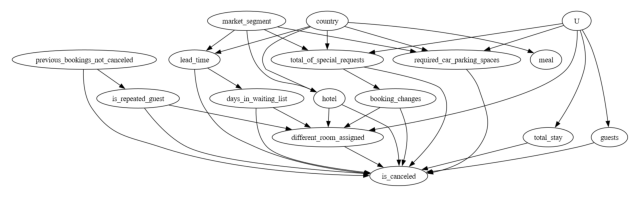

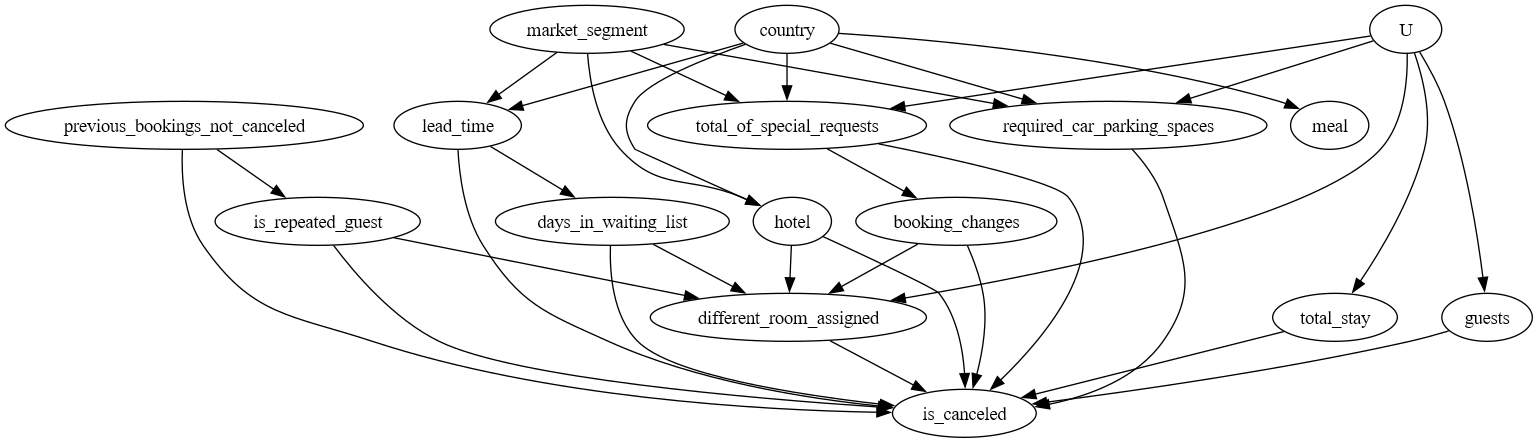

In [ ]:
model= dowhy.CausalModel(
        data = dataset,
        graph=causal_graph.replace("\n", " "),
        treatment="different_room_assigned",
        outcome='is_canceled')
model.view_model()
from IPython.display import Image, display
display(Image(filename="causal_model.png"))

Step-2. Identify the Causal Effect

#Identify the causal effect
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

In [ ]:
#Identify the causal effect
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
            d                                                                 
──────────────────────────(E[is_canceled|total_stay,total_of_special_requests,
d[different_room_assigned]                                                    

                                                                              
booking_changes,required_car_parking_spaces,guests,hotel,lead_time,days_in_wai
                                                                              

                             
ting_list,is_repeated_guest])
                             
Estimand assumption 1, Unconfoundedness: If U→{different_room_assigned} and U→is_canceled then P(is_canceled|different_room_assigned,total_stay,total_of_special_requests,booking_changes,required_car_parking_spaces,guests,hotel,lead_time,days_in_waiting_list,is_repeated_guest,U) = P(is_canceled|different_room_assigned,total_

In [ ]:
estimate = model.estimate_effect(identified_estimand,
                                 method_name="backdoor.propensity_score_weighting",target_units="ate")
# ATE = Average Treatment Effect
# ATT = Average Treatment Effect on Treated (i.e. those who were assigned a different room)
# ATC = Average Treatment Effect on Control (i.e. those who were not assigned a different room)
print(estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
            d                                                                 
──────────────────────────(E[is_canceled|total_stay,total_of_special_requests,
d[different_room_assigned]                                                    

                                                                              
booking_changes,required_car_parking_spaces,guests,hotel,lead_time,days_in_wai
                                                                              

                             
ting_list,is_repeated_guest])
                             
Estimand assumption 1, Unconfoundedness: If U→{different_room_assigned} and U→is_canceled then P(is_canceled|different_room_assigned,total_stay,total_of_special_requests,booking_changes,required_car_parking_spaces,guests,hotel,lead_time,days_in_waiting_list,is_repeated_guest,U

Step-4. Refute results
Note that the causal part does not come from data. It comes from your assumptions that lead to identification. Data is simply used for statistical estimation. Thus it becomes critical to verify whether our assumptions were even correct in the first step or not!

What happens when another common cause exists? What happens when the treatment itself was placebo?

In [ ]:
##Random Common Cause:- Adds randomly drawn covariates to data and re-runs the analysis to see if the causal estimate changes or not. If our assumption was originally correct then the causal estimate shouldn’t change by much
refute1_results=model.refute_estimate(identified_estimand, estimate,
        method_name="random_common_cause")
print(refute1_results)


Refute: Add a random common cause
Estimated effect:-0.26217379744632086
New effect:-0.26217379744632074
p value:1.0



In [ ]:
## Method-2: Placebo Treatment Refuter:- Randomly assigns any covariate as a treatment and re-runs the analysis. If our assumptions were correct then this newly found out estimate should go to 0.
refute2_results=model.refute_estimate(identified_estimand, estimate,
        method_name="placebo_treatment_refuter")
print(refute2_results)


Refute: Use a Placebo Treatment
Estimated effect:-0.26217379744632086
New effect:0.05565936392897939
p value:0.0



In [ ]:
## Method-3: Data Subset Refuter:- Creates subsets of the data(similar to cross-validation) and checks whether the causal estimates vary across subsets. If our assumptions were correct there shouldn’t be much variation.

refute3_results=model.refute_estimate(identified_estimand, estimate,
        method_name="data_subset_refuter")
print(refute3_results)

Refute: Use a subset of data
Estimated effect:-0.26217379744632086
New effect:-0.2622400998030691
p value:0.94

